In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import seaborn as sns

What network should we use where?

In [16]:
files = [
    f"../data/output/model.{i}/0/1/columns.nc"
    for i in range(3)
]
truth_path = "../data/output/truth.nc"

In [17]:
truth = xr.open_dataset(truth_path)
w = truth.layer_mass

In [58]:
def plot_qt(file, x=0, y=18):
    (xr.open_dataset(file).qt - truth.qt.mean(['time', 'x'])).isel(x=x, y=y).plot.contourf(y='z')
    
def plot_sl(file, x=0, y=18, **kw):
    (xr.open_dataset(file).sl - truth.sl.mean(['time', 'x'])).isel(x=x, y=y).plot.contourf(y='z', **kw)

def error(file):
    ds = xr.open_dataset(file)
    return ((((ds - truth))**2*w).mean(['x', 'time', 'z'])/w.mean('z'))\
               .apply(np.sqrt)
    

In [19]:
# compute the errors for each network
errors = xr.concat([error(path) for i, path in enumerate(files)], dim='region')

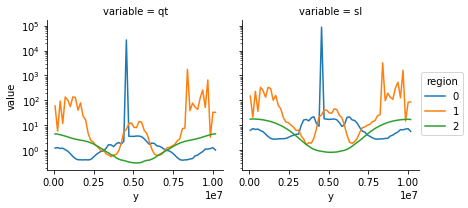

In [7]:
melted = errors.to_array().to_dataframe(name='value').reset_index()

fg = sns.FacetGrid(col="variable", hue="region", data=melted)
fg.map(plt.semilogy, "y", "value")
fg.add_legend()

The model trained on region 1 seems to perform worse than the other two models. This suggests that we should only use the region 0 (extra tropics) and region 2 (tropics) models. What does the tropics model looks like in the extra tropics?

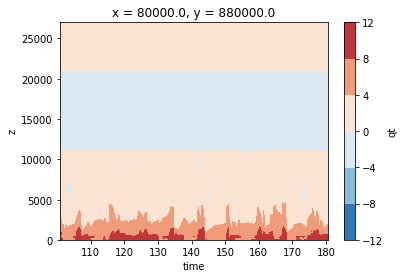

In [49]:
plot_qt(files[2], y=5)

It is far to moist. And vice versa?

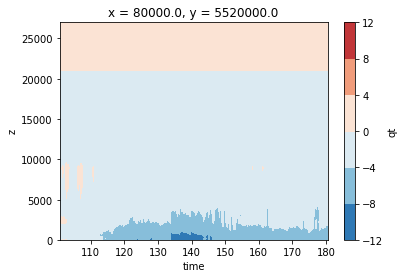

In [50]:
plot_qt(files[0], y=34)

The extratropics network dries out the atmosphere. What about the temperature field?

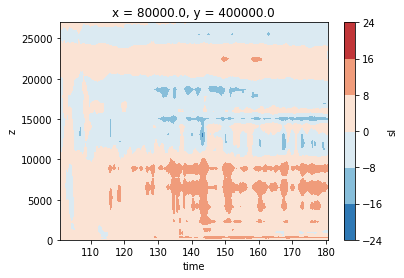

In [51]:
plot_sl(files[0], y=2)

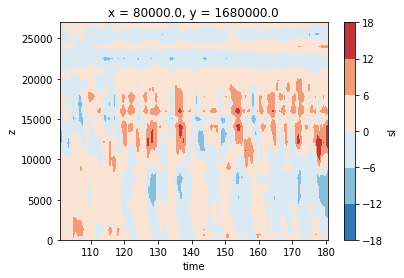

In [52]:
plot_sl(files[0], y=10)

The extra tropics model makes a very large bias near the edge of the domain, but it does better near the middle of its training region. Perhaps the model needs additional inputs at the edges, or we should train another network for just the 5 or so points near the edge of the domain. Ideally, we could find a model which works for the whole domain in one training procedure. I think a mixture of experts might be the way to go, but that might be hard to code up. Alternatively we could try to change the input variables (maybe RH would be better).

# Globally trained deep network

I trained a model with 3 hidden layers (each w/ 512 nodes) on the whole dataset. It took a very long time to train (around 3 hours), but does this work better?

In [21]:
global_path = "../data/output/model.global/0/3/columns.nc"

err_glob = error(global_path)

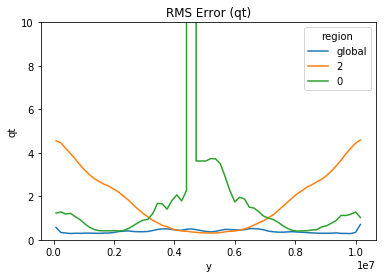

In [41]:
def plot_rms(field):
    err_glob[field].plot(label='global')
    errors.sel(region=2)[field].plot(label='2')
    errors.sel(region=0)[field].plot(label='0')
    plt.ylim([0, 10])
    plt.legend(title="region")
    plt.title(f"RMS Error ({field})")
    
plot_rms('qt')

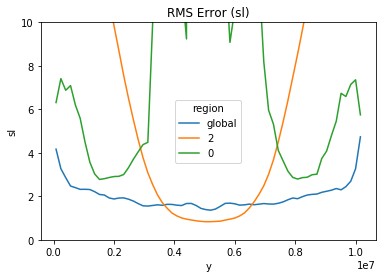

In [42]:
plot_rms('sl')

We see that the globally trained network does better almost everwhere. But the networks trained on individual regions approach or exceed the accuracy in some narrow regions. The tropically trained model outperforms the global model near the equator. Let's look at some time series to get a character of the solutions.

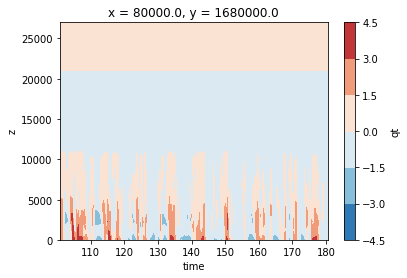

In [53]:
plot_qt(global_path, y=10)

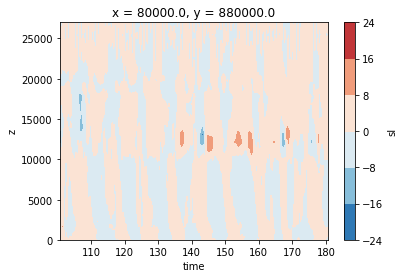

In [74]:
plot_sl(truth_path, y=5)

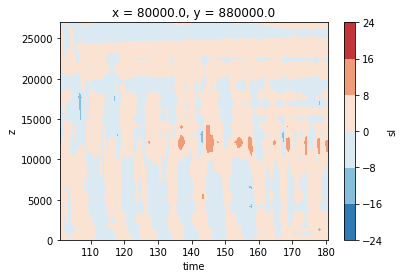

In [76]:
plot_sl(global_path, y=5, vmax=24)

Unfortunately, it still seems to suffer from a warm bias in the upper atmosphere, but this bias is not that as severe as before. I suspect more training would help.